Data API is [here](https://www.hikingproject.com/data).

Google data for hikes!

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Hiking Project

In [72]:
trail_df_two = pd.read_csv('hiking_two.csv')

In [73]:
trail_df = pd.read_csv('hiking.csv')

In [74]:
trail_df = trail_df.append(trail_df_two, ignore_index=True)

In [77]:
trail_df.head()

,id,name,summary,difficulty,stars,star_votes,location,url,length,ascent,descent,high,low,longitude,latitude,cond_status,cond_details,cond_date
0,7003796,Section 16/Palmer Loop,A favorite loop in the Springs area.,blue,4.5,72,"Manitou Springs, Colorado",https://www.hikingproject.com/data/,5.9,1287,-1288,7845,6633,-104.8903,38.8228,All Clear,NaN,2019-09-19 15:04:39
1,7006769,Castlewood Canyon - Rimrock to Creek Bottom Loop,"A fun, rolling trail with a sense of seclusion...",blue,4.6,45,"Castle Rock, Colorado",https://www.hikingproject.com/data/,4.6,610,-612,6561,6163,-104.7682,39.3598,Minor Issues,Snowy - Still a few slippery patches on rocky ...,2019-10-12 12:44:28
2,7022212,Garden of the Gods Loop,A longer loop in this spectacular area allows ...,greenBlue,4.1,45,"Manitou Springs, Colorado",https://www.hikingproject.com/data/,4.0,414,-414,6588,6291,-104.8802,38.8815,All Clear,Dry,2019-08-10 15:45:14
3,7032321,Harrison Crash Site via Ice Cave,A truly beautiful hike following Ice Cave Cree...,blueBlack,4.9,15,"Palmer Lake, Colorado",https://www.hikingproject.com/data/,11.1,2066,-2065,8540,7231,-104.9213,39.1187,Unknown,NaN,1970-01-01 00:00:00
4,7018077,Mt. Muscoco,"Easily accessible from Colorado Spings, with v...",blue,4.4,28,"Manitou Springs, Colorado",https://www.hikingproject.com/data/,2.0,1248,-17,7964,6733,-104.8871,38.7918,All Clear,Dry - Awesome Hike!,2019-09-02 21:52:17


In [78]:
for column in trail_df.columns:
    print('{} unique values: {}'.format(column, trail_df[column].nunique()))

id unique values: 13945
name unique values: 12764
summary unique values: 9394
difficulty unique values: 7
stars unique values: 35
star_votes unique values: 97
location unique values: 1984
url unique values: 1
length unique values: 427
ascent unique values: 3248
descent unique values: 2632
high unique values: 7363
low unique values: 6673
longitude unique values: 12599
latitude unique values: 12182
cond_status unique values: 4
cond_details unique values: 551
cond_date unique values: 1611


In [79]:
test_dup_name = trail_df.name[0]

trail_df.loc[trail_df.name == test_dup_name].reset_index(drop=True)[:5]

,id,name,summary,difficulty,stars,star_votes,location,url,length,ascent,descent,high,low,longitude,latitude,cond_status,cond_details,cond_date
0,7003796,Section 16/Palmer Loop,A favorite loop in the Springs area.,blue,4.5,72,"Manitou Springs, Colorado",https://www.hikingproject.com/data/,5.9,1287,-1288,7845,6633,-104.8903,38.8228,All Clear,NaN,2019-09-19 15:04:39
1,7003796,Section 16/Palmer Loop,A favorite loop in the Springs area.,blue,4.5,72,"Manitou Springs, Colorado",https://www.hikingproject.com/data/,5.9,1287,-1288,7845,6633,-104.8903,38.8228,All Clear,NaN,2019-09-19 15:04:39
2,7003796,Section 16/Palmer Loop,A favorite loop in the Springs area.,blue,4.5,72,"Manitou Springs, Colorado",https://www.hikingproject.com/data/,5.9,1287,-1288,7845,6633,-104.8903,38.8228,All Clear,NaN,2019-09-19 15:04:39
3,7003796,Section 16/Palmer Loop,A favorite loop in the Springs area.,blue,4.5,72,"Manitou Springs, Colorado",https://www.hikingproject.com/data/,5.9,1287,-1288,7845,6633,-104.8903,38.8228,All Clear,NaN,2019-09-19 15:04:39
4,7003796,Section 16/Palmer Loop,A favorite loop in the Springs area.,blue,4.5,72,"Manitou Springs, Colorado",https://www.hikingproject.com/data/,5.9,1287,-1288,7845,6633,-104.8903,38.8228,All Clear,NaN,2019-09-19 15:04:39


Oh yes, there are lots of duplicates. Let's correct that.

In [80]:
df = pd.DataFrame(columns=trail_df.columns)

for trail in trail_df.name.unique().tolist():
    temp_df = trail_df.loc[trail_df.name == trail].reset_index()
    df = df.append(temp_df.loc[0, :], ignore_index=True)
    
df.head()

,id,name,summary,difficulty,stars,star_votes,location,url,length,ascent,descent,high,low,longitude,latitude,cond_status,cond_details,cond_date,index
0,7003796,Section 16/Palmer Loop,A favorite loop in the Springs area.,blue,4.5,72,"Manitou Springs, Colorado",https://www.hikingproject.com/data/,5.9,1287,-1288,7845,6633,-104.8903,38.8228,All Clear,NaN,2019-09-19 15:04:39,0.0
1,7006769,Castlewood Canyon - Rimrock to Creek Bottom Loop,"A fun, rolling trail with a sense of seclusion...",blue,4.6,45,"Castle Rock, Colorado",https://www.hikingproject.com/data/,4.6,610,-612,6561,6163,-104.7682,39.3598,Minor Issues,Snowy - Still a few slippery patches on rocky ...,2019-10-12 12:44:28,1.0
2,7022212,Garden of the Gods Loop,A longer loop in this spectacular area allows ...,greenBlue,4.1,45,"Manitou Springs, Colorado",https://www.hikingproject.com/data/,4.0,414,-414,6588,6291,-104.8802,38.8815,All Clear,Dry,2019-08-10 15:45:14,2.0
3,7032321,Harrison Crash Site via Ice Cave,A truly beautiful hike following Ice Cave Cree...,blueBlack,4.9,15,"Palmer Lake, Colorado",https://www.hikingproject.com/data/,11.1,2066,-2065,8540,7231,-104.9213,39.1187,Unknown,NaN,1970-01-01 00:00:00,3.0
4,7018077,Mt. Muscoco,"Easily accessible from Colorado Spings, with v...",blue,4.4,28,"Manitou Springs, Colorado",https://www.hikingproject.com/data/,2.0,1248,-17,7964,6733,-104.8871,38.7918,All Clear,Dry - Awesome Hike!,2019-09-02 21:52:17,4.0


We don't want to repeat this process, so let's save this duplicate free df as a csv.

In [82]:
df.to_csv('hiking_no_dups.csv', index=False)

# EDA

In [172]:
df = pd.read_csv('hiking_no_dups.csv')

Let's create new features for our city and state.

In [173]:
#new lists to create state and city specific
city = []
state = []

#seperate each city and state then append to our lists
for i in range(len(df)):
    city_state = df.location[i].split(',')
    city.append(city_state[0])
    state.append(city_state[1].strip())
    
#add our list to our df
df['city'] = city
df['state'] = state

In [174]:
df = df.drop(columns='index')
df.head(2)

,id,name,summary,difficulty,stars,star_votes,location,url,length,ascent,descent,high,low,longitude,latitude,cond_status,cond_details,cond_date,city,state
0,7003796,Section 16/Palmer Loop,A favorite loop in the Springs area.,blue,4.5,72,"Manitou Springs, Colorado",https://www.hikingproject.com/data/,5.9,1287,-1288,7845,6633,-104.8903,38.8228,All Clear,NaN,2019-09-19 15:04:39,Manitou Springs,Colorado
1,7006769,Castlewood Canyon - Rimrock to Creek Bottom Loop,"A fun, rolling trail with a sense of seclusion...",blue,4.6,45,"Castle Rock, Colorado",https://www.hikingproject.com/data/,4.6,610,-612,6561,6163,-104.7682,39.3598,Minor Issues,Snowy - Still a few slippery patches on rocky ...,2019-10-12 12:44:28,Castle Rock,Colorado


In [175]:
df.isnull().sum() / len(df) * 100

id               0.000000
name             0.000000
summary          6.972736
difficulty       0.000000
stars            0.000000
star_votes       0.000000
location         0.000000
url              0.000000
length           0.000000
ascent           0.000000
descent          0.000000
high             0.000000
low              0.000000
longitude        0.000000
latitude         0.000000
cond_status      0.000000
cond_details    88.569414
cond_date        0.000000
city             0.000000
state            0.000000
dtype: float64

In [176]:
df = df.drop(columns='cond_details')
df = df.dropna().reset_index(drop=True)

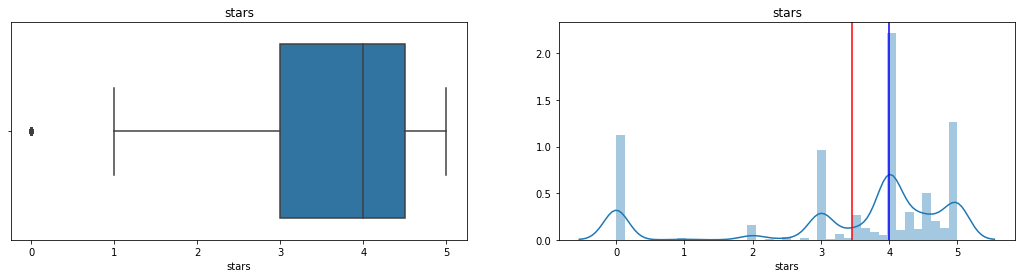

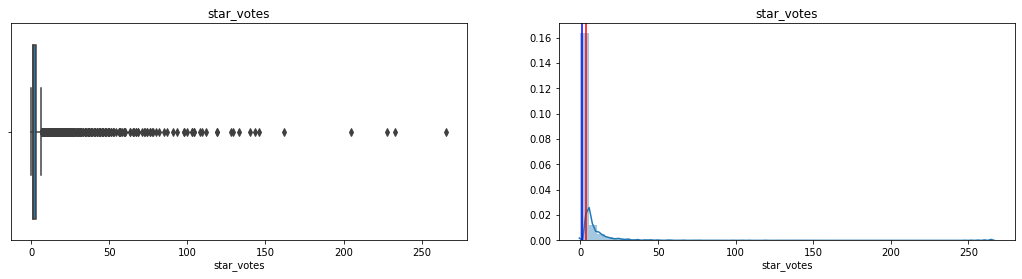

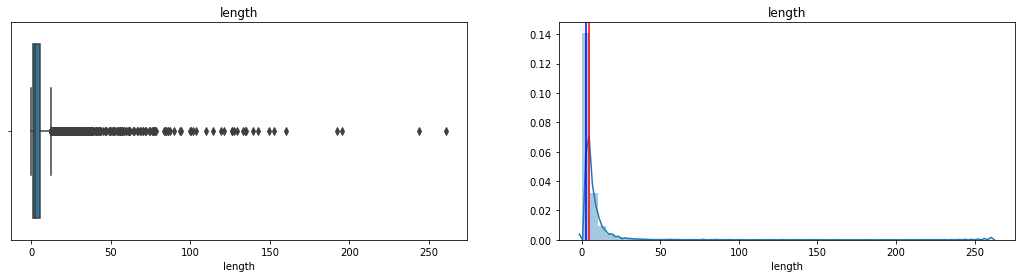

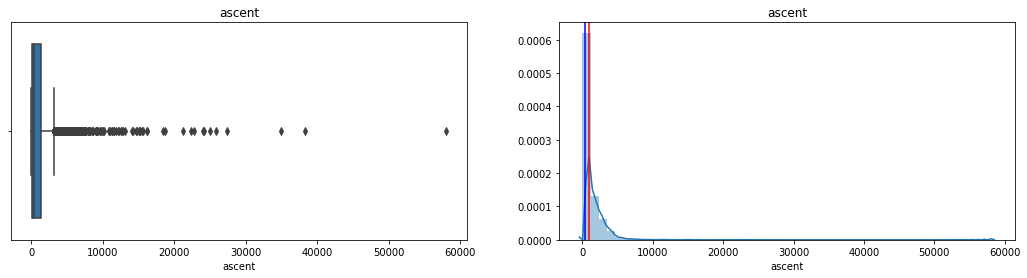

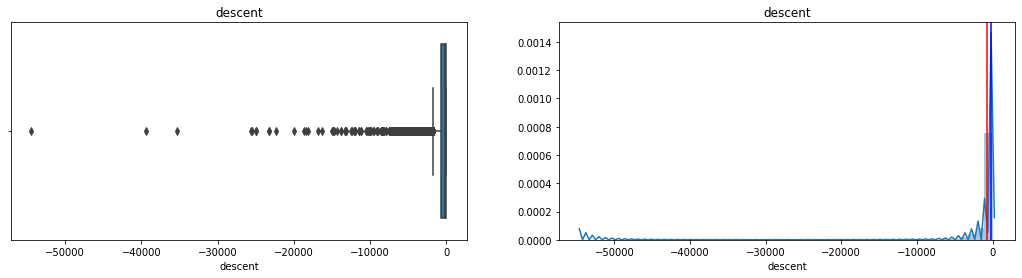

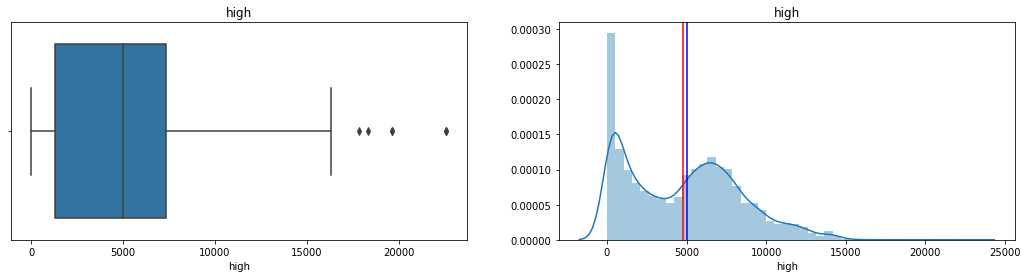

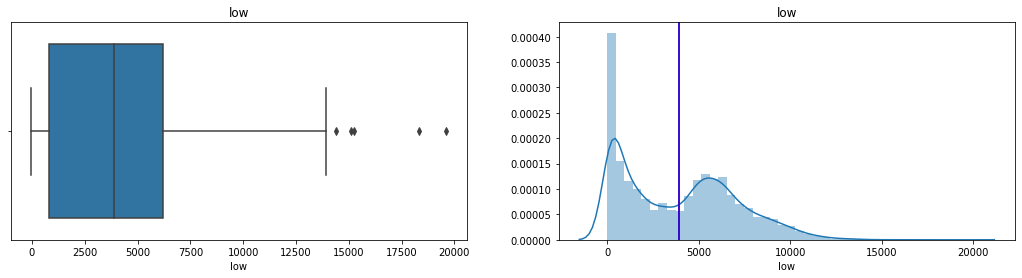

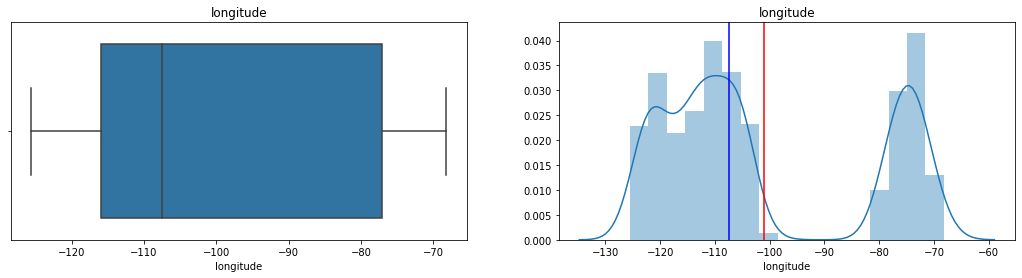

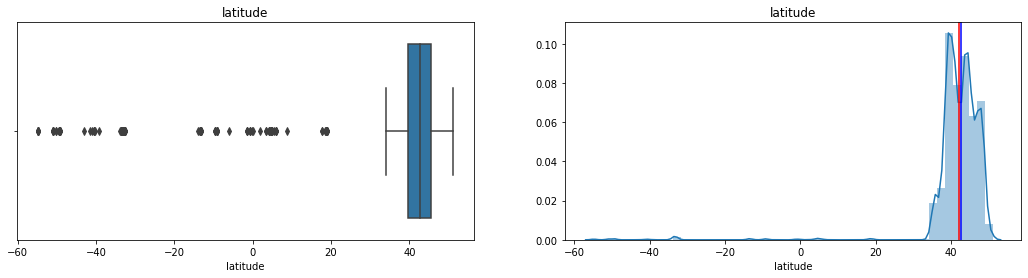

In [177]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])
cat_df = df.loc[:, ~df.columns.isin(numeric_df.columns)]

for column in numeric_df.columns:
    if column != 'id':
        plt.figure(figsize=(18, 4))
        
        plt.subplot(1, 2, 1)
        sns.boxplot(df[column])
        plt.title('{}'.format(column))
        
        plt.subplot(1, 2, 2)
        sns.distplot(df[column])
        plt.axvline(df[column].mean(), color='red')
        plt.axvline(df[column].median(), color='blue')
        plt.title('{}'.format(column))
        
        plt.show()

In [178]:
for column in cat_df.columns:
    print('{}: {}'.format(column, df[column].nunique()))

name: 11874
summary: 8669
difficulty: 7
location: 1879
url: 1
cond_status: 4
cond_date: 1525
city: 1759
state: 43


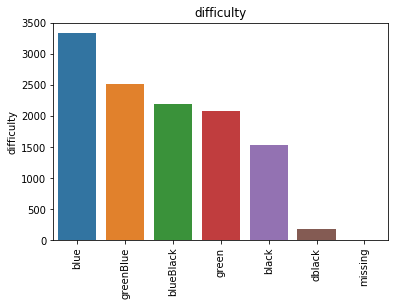

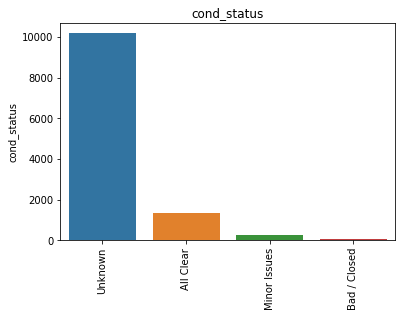

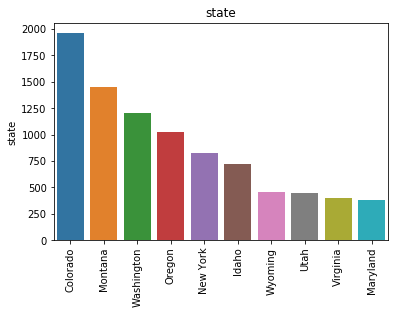

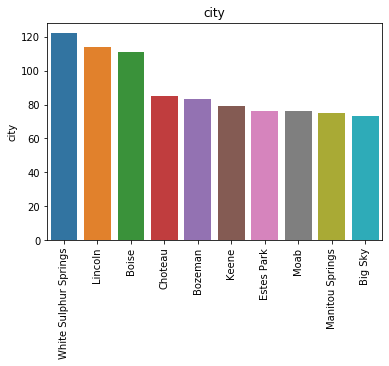

In [179]:
cat = ['difficulty', 'cond_status', 'state', 'city']

for column in cat:
    names = list(df[column].value_counts().index[:10])
    value = df[column].value_counts()[:10]
    plt.title('{}'.format(column))
    sns.barplot(names, value)
    plt.xticks(rotation='vertical')
    plt.show()

Well, we know that our difficulty category is ranked, so let's make a new feature for the difficulty.

In [180]:
df.difficulty.value_counts()

blue         3336
greenBlue    2522
blueBlack    2205
green        2092
black        1530
dblack        176
missing        13
Name: difficulty, dtype: int64

In [181]:
difficulties = ['green', 'greenBlue', 'blue', 'blueBlack', 'black', 'dblack']

#our function returns the index (from 0 - 5) or null
def convert_difficulty(value):
    if value in difficulties:
        return difficulties.index(value)
    else:
        return np.nan

df['diff_ranked'] = df['difficulty'].apply(lambda x: convert_difficulty(x))

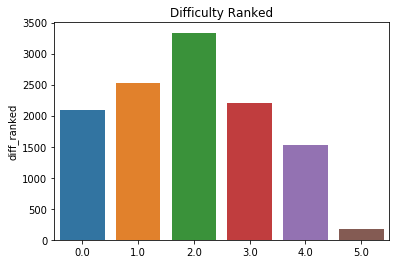

In [182]:
names = df.diff_ranked.value_counts().sort_index().index
values = df.diff_ranked.value_counts().sort_index()

sns.barplot(names, values)
plt.title('Difficulty Ranked')
plt.show()

# Summary EDA

In [183]:
df['summary'][:10]

0                 A favorite loop in the Springs area.
1    A fun, rolling trail with a sense of seclusion...
2    A longer loop in this spectacular area allows ...
3    A truly beautiful hike following Ice Cave Cree...
4    Easily accessible from Colorado Spings, with v...
5    An excellent, but short, loop through the hear...
6    A hike with creeks, bridges, scree slopes, for...
7    A solid ascent along the ridge northwest of th...
8    Widely recognized as one of the best urban tra...
9    This 750 acre park features geological formati...
Name: summary, dtype: object

In [184]:
summary_length = []

for i in range(len(df['summary'])):
    summary_length.append(len(df['summary'][i]))
    
print('Our df is {} long and we have {} summary lengths.'.format(len(df), len(summary_length)))
print('The average is {} and the median is {} --- std {}'.format(np.mean(summary_length), np.median(summary_length), np.std(summary_length)))

Our df is 11874 long and we have 11874 summary lengths.
The average is 57.374094660603 and the median is 60.0 --- std 33.48130321199061


In [185]:
df['summary_length'] = df['summary'].apply(lambda x: len(x))

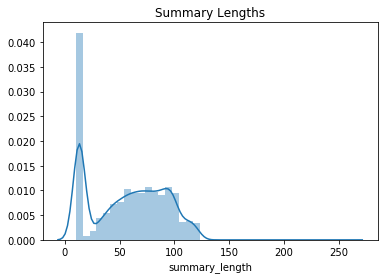

In [186]:
sns.distplot(df['summary_length'])
plt.title('Summary Lengths')
plt.show()

In [187]:
for i in range(int(len(df['summary']) / 50)):
    if len(df['summary'][i]) == 13:
        print(df['summary'][i])

To be written
Needs Summary
Needs Summary
Needs Summary
Needs Summary
Needs Summary
Needs Summary
Needs Summary
Needs Summary
Needs Summary
Needs Summary
Needs Summary
Needs Summary
Needs Summary
Needs Summary
Needs Summary
Needs Summary
Needs Summary


In [188]:
df['summary'] = df['summary'].str.lower()
needs_summary = df.loc[df.summary.str.contains('summary')]
needs_summary.summary.value_counts()

needs summary                                 2698
needs summary and description.                  30
this trail could use a short summary!           14
needs summary.                                   6
this trail needs a summary!                      2
needs summary!                                   1
summary here.                                    1
this trail could use a summary!                  1
this trail needs a summary                       1
needs summary and an expanded description.       1
Name: summary, dtype: int64

In [189]:
small_summaries = df.loc[df.summary_length <= 20]

small_summaries.summary.value_counts()[:10]

needs summary          2698
needs adoption          347
needs adoption!          26
coming soon              11
adopt me, please!         9
adopt this trail!         8
to be written             7
needs summary.            6
needs adoption.           6
a paved loop trail.       2
Name: summary, dtype: int64

In [190]:
needs_adoption = df.loc[df.summary.str.contains('adopt')]
needs_adoption.summary.value_counts()

needs adoption       347
needs adoption!       26
adopt me, please!      9
adopt this trail!      8
needs adoption.        6
adopt me please!       1
Name: summary, dtype: int64

In [191]:
df['summary'] = df['summary'].apply(lambda x: np.nan if 'summary' in x or 'adopt' in x else x)
df['summary']

0                     a favorite loop in the springs area.
1        a fun, rolling trail with a sense of seclusion...
2        a longer loop in this spectacular area allows ...
3        a truly beautiful hike following ice cave cree...
4        easily accessible from colorado spings, with v...
                               ...                        
11869    hike through fields of wildflowers and along a...
11870    h island is located in the beagle channel and ...
11871    a day trip to martial glacier for the best vie...
11872    laguna del caminante to ushuaia via cañadon de...
11873    this short easy trail leads to a cascade viewp...
Name: summary, Length: 11874, dtype: object

In [192]:
df = df.dropna().reset_index()

Let's start building our first content similarity model.

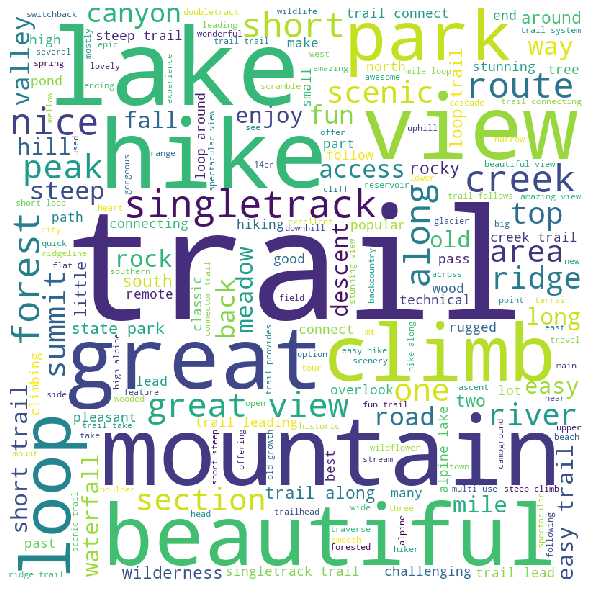

In [194]:
from wordcloud import WordCloud, STOPWORDS 

comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in df.summary: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [195]:
import re

def text_cleaner(text):
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

df['sent_combined'] = df['summary'] + ' ' + df['difficulty']

In [196]:
df['sent_combined'] = df['sent_combined'].apply(lambda x: text_cleaner(x))

## Count Vectorizer

In [197]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', max_features=100)

vector = vectorizer.fit_transform(df['sent_combined'])

columns = vectorizer.get_feature_names()

bow = pd.DataFrame(vector.toarray(), columns=columns)

In [198]:
partial_df = df[['stars', 'length', 'ascent', 'descent', 'high', 'low']]

In [201]:
X = pd.concat([bow, partial_df], axis=1)

In [203]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(X, X)

In [225]:
series = pd.Series(cosine_sim[0]).sort_values(ascending=False)

indexes = list(series.index[1: 11])

for i in indexes:
    print(df.name[i])

Blaine Basin
Dome Rock Loop Trail
Hewlett Gulch Trail #954
Apex-Enchanted Lollipop
Green Lake Trail
Iverson Railroad Trail
Sunnyside–Radio Tower
James Peak (13,294') from Corona Pass Road
Red Deer Lake
The Living Room


In [267]:
#function that takes a hike as input and returns the top 10 hikes
def recommendations(name):
    
    # initializing the empty list of recommended hikes
    recommended_hikes = pd.DataFrame(columns = df.columns)
    
    # getting the index of the movie that matches the title
    index = df.loc[df.name == name].index.tolist()
    
    series = pd.Series(cosine_sim[index[0]]).sort_values(ascending=False)
    
    indexes = list(series.index[1: 11])
    
    for i in indexes:
        recommended_hikes = recommended_hikes.append(df.loc[i, :])
        
    return recommended_hikes

In [269]:
test_name = df.name[0]
test_df = recommendations(test_name)

In [270]:
test_df

,index,id,name,summary,difficulty,stars,star_votes,location,url,length,...,low,longitude,latitude,cond_status,cond_date,city,state,diff_ranked,summary_length,sent_combined
1626,1854,7005435,Blaine Basin,a hike with great solitude to stunning blaine ...,blue,4.3,4,"Telluride, Colorado",https://www.hikingproject.com/data/,6.8,...,9382,-107.8078,38.0338,Unknown,1970-01-01 00:00:00,Telluride,Colorado,2.0,80,a hike with great solitude to stunning blaine ...
362,448,7041405,Dome Rock Loop Trail,a lengthy trail along three creeks to dome roc...,blue,4.5,6,"Cripple Creek, Colorado",https://www.hikingproject.com/data/,10.8,...,8208,-105.1744,38.8394,All Clear,2019-09-08 11:43:39,Cripple Creek,Colorado,2.0,119,a lengthy trail along three creeks to dome roc...
641,746,7015874,Hewlett Gulch Trail #954,a fun trail to let your dog off the leash with...,greenBlue,4.3,19,"Laporte, Colorado",https://www.hikingproject.com/data/,8.4,...,5729,-105.3104,40.6895,All Clear,2019-07-31 08:26:10,Laporte,Colorado,1.0,84,a fun trail to let your dog off the leash with...
484,585,7029252,Apex-Enchanted Lollipop,this is one of the best hikes on the front range.,blue,4.2,57,"West Pleasant View, Colorado",https://www.hikingproject.com/data/,5.7,...,6172,-105.2098,39.7162,All Clear,2019-07-28 12:51:13,West Pleasant View,Colorado,2.0,49,this is one of the best hikes on the front ran...
1103,1237,7009429,Green Lake Trail,a steep out and back to green lake.,blue,4.4,9,"Crested Butte, Colorado",https://www.hikingproject.com/data/,9.4,...,8938,-106.9876,38.8672,Unknown,1970-01-01 00:00:00,Crested Butte,Colorado,2.0,35,a steep out and back to green lake. blue
2966,3964,7002024,Iverson Railroad Trail,a great singletrack addition to the traditiona...,blue,4.0,2,"Mirrormont, Washington",https://www.hikingproject.com/data/,1.5,...,1467,-121.9588,47.4691,Unknown,1970-01-01 00:00:00,Mirrormont,Washington,2.0,74,a great singletrack addition to the traditiona...
1082,1215,7030615,Sunnyside–Radio Tower,the best out-and-back hike high above the vall...,blueBlack,4.5,2,"Aspen, Colorado",https://www.hikingproject.com/data/,4.8,...,7845,-106.8421,39.2156,Unknown,1970-01-01 00:00:00,Aspen,Colorado,3.0,120,the best out-and-back hike high above the vall...
863,977,7052870,"James Peak (13,294') from Corona Pass Road","start just below tree line, climb to and trave...",blue,4.0,1,"Winter Park, Colorado",https://www.hikingproject.com/data/,8.6,...,11125,-105.7077,39.8988,Unknown,1970-01-01 00:00:00,Winter Park,Colorado,2.0,108,"start just below tree line, climb to and trave..."
709,815,7002461,Red Deer Lake,a beautiful creekside hike in an awesome mount...,blue,4.5,14,"Nederland, Colorado",https://www.hikingproject.com/data/,14.2,...,8703,-105.5240,40.1299,Bad / Closed,2019-09-28 17:51:09,Nederland,Colorado,2.0,58,a beautiful creekside hike in an awesome mount...
1405,1566,7017456,The Living Room,"a short, moderately steep hike up red butte wi...",blue,4.3,22,"Salt Lake City, Utah",https://www.hikingproject.com/data/,2.4,...,5017,-111.8214,40.7594,Unknown,1970-01-01 00:00:00,Salt Lake City,Utah,2.0,114,"a short, moderately steep hike up red butte wi..."
